In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from abc import ABC, abstractmethod
sns.set()

# DEFINING K-Bandit

In [12]:
def get_reward(action_pred):
        if action_pred==0:
            if np.random.random()<0.13:
                return 252
            else:
                return 10
        elif action_pred==1:
            return np.random.choice(np.arange(8,18,1))
        elif action_pred==2:
            if np.random.random()<0.19:
                return 26
            else:
                return 6

In [13]:
def plot(dict_rewards,to_average=100,name='undefined',name_changing='epsilon'):
    plt.figure(figsize=(15,12))
    if len(dict_rewards)>1:
        plt.title('Different experiments with respect to {0} using {1}'.format(name_changing,name))
    else:
        plt.title('{0}'.format(name))
    for v in dict_rewards.values():
        to_plot = [np.mean(v[i:i+to_average]) for i in range(0,len(v),to_average)]
        plt.plot(range(len(to_plot)),to_plot)
    plt.legend(list(dict_rewards.keys()))

In [14]:
class Bandit:
    def __init__(self,actions,step_size,name='undefined'):
        self.actions = actions
        self.step_size = step_size
        self.rewards = []
        self.name = name
        if not self.step_size:
            self.dynamic_alpha = True
        else:
            self.dynamic_alpha = False
        self.value_table = np.zeros((len(self.actions),),dtype='float16')
        self.freq_table = np.zeros((len(self.actions)),dtype='uint8')
    
    def uniform(self):
        action  = np.random.choice(self.actions)
        return action
    
    def argmax(self,list_values):
        maximum = np.max(list_values)
        max_values = np.where(list_values==maximum)[0]
        if max_values.size>1:
            idx = np.random.choice(max_values)
            return idx
        else:
            return np.argmax(list_values)
        
    @abstractmethod
    def iterate(self, num_iterations=100):
        '''
        Trains Bandit
        num_iterations - number of iterations
        '''
        pass
    
    def get_action_values_table(self):
        return self.value_table
    
    def get_rewards(self):
        return self.rewards
    
    def get_name(self):
        return self.name

In [15]:
class GreedyEpsilonBandit(Bandit):
    def __init__(self,actions, step_size=0.5,epsilon=0.7,name='undefined'):
        super().__init__(actions,step_size,name=name)
        self.epsilon = epsilon
    
        
    def iterate(self,num_iterations=100):
        for iteration in tqdm(range(num_iterations)):
                if iteration==0:
                    action = self.uniform()
                else:
                    if np.random.random_sample()<self.epsilon:
                        action = self.uniform() 
                    else:
                        action = self.argmax(self.value_table)
                self.freq_table[action]+=1
                reward = get_reward(action)
                self.rewards.append(reward)
                if self.dynamic_alpha:
                    step_size=1/(self.freq_table[action])
                else:
                    step_size = self.step_size
                    
                self.value_table[action]+=step_size*(reward-self.value_table[action])
                
            

In [18]:
class OptimisticBandit(Bandit):
    def __init__(self,actions, step_size=0.5,optimistic_value=11,name='undefined'):
        super().__init__(actions,step_size,name=name)
        self.value_table = np.full((len(self.actions,)),optimistic_value,dtype='float16')        
        
    def iterate(self,num_iterations=100):
        for iteration in tqdm(range(num_iterations)):
                if iteration==0:
                    action = self.uniform()
                else:
                    action = self.argmax(self.value_table)
                self.freq_table[action]+=1
                reward = get_reward(action)
                self.rewards.append(reward)
                if self.dynamic_alpha:
                    step_size=1/(self.freq_table[action])
                else:
                    step_size = self.step_size
                    
                self.value_table[action]+=step_size*(reward-self.value_table[action])
                
            

In [20]:
class UCBBandit(Bandit):
    def __init__(self,actions,step_size=None, c=2,name='undefined'):
        super().__init__(actions,step_size,name=name)
        self.c = c
    
    def argmax(self,value_table,iteration):
        ucb = value_table+self.c*np.sqrt(np.log(iteration+1)/self.freq_table)
        ucb[np.isnan(ucb)] = float("inf")
        maximum = np.max(ucb)
        max_values = np.where(ucb==maximum)[0]
        if max_values.size>1:
            return np.random.choice(max_values)
        else:
            return np.argmax(ucb)
        
    def iterate(self,num_iterations):
        for iteration in tqdm(range(num_iterations)):
                action = self.argmax(self.value_table,iteration)   
                self.freq_table[action]+=1
                reward = get_reward(action)
                self.rewards.append(reward)
                if self.dynamic_alpha:
                    step_size=1/(self.freq_table[action])
                else:
                    step_size = self.step_size
                    
                self.value_table[action]+=step_size*(reward-self.value_table[action])

In [23]:
class ThompsonBandit(Bandit):
    def __init__(self,actions,step_size=None,name='undefined'):
        self.a = np.ones(len(actions)) 
        self.b = np.ones(len(actions)) 
        self.theta = np.zeros(len(actions))
        super().__init__(actions,step_size,name=name)
    
    
    def iterate(self,num_iterations):
        for iteration in tqdm(range(num_iterations)):
            self.theta = np.random.beta(self.a, self.b)
            action = self.actions[np.argmax(self.theta)]
            reward = get_reward(action)
            self.rewards.append(reward)
            self.a[action] += reward
            self.b[action] += 252 - reward
            

In [16]:
def run_experiments(runs,iterations,name='optimistic'):
    assert name in ['optimistic','epsilons','ucb','thompson'], 'name of experiment shoud be on of optimistic, epsilons or ubc'
    actions = [0,1,2]
    epsilons = [0, 0.01, 0.1]
    step_size = [None, 0.1, 0.5]
    c = [0,2,3]
    dict_rewards = {}
    if name=='epsilons':
        dict_rewards = dict((k,np.zeros((iterations,))) for k in epsilons)
        for run in range(runs):
            for i in epsilons:
                bandit = GreedyEpsilonBandit(actions,None,i,name='GreedyEpsilonBandit')
                bandit.iterate(iterations)
                rewards = bandit.get_rewards()
                dict_rewards.update({i:np.add(np.array(rewards),np.array(dict_rewards.get(i)))})
        dict_rewards = dict((k,v/runs) for k,v in dict_rewards.items())
        plot(dict_rewards,name='GreedyEpsilonBandit',name_changing='epsilon')
    elif name=='optimistic':
        dict_rewards = dict((k,np.zeros((iterations,))) if k else ('dynamic',np.zeros((iterations,)))  for k in step_size)
        for run in range(runs):
            for i in step_size:
                bandit = OptimisticBandit(actions,step_size=i,name='OptimisticBandit')
                bandit.iterate(iterations)
                rewards = bandit.get_rewards()
                if not i:
                    i='dynamic'
                dict_rewards.update({i:np.add(np.array(rewards),np.array(dict_rewards.get(i)))})
        dict_rewards = dict((k,v/runs) for k,v in dict_rewards.items())
        plot(dict_rewards,name='OptimisticBandit',name_changing='step size')
    elif name=='ucb':
        dict_rewards = dict((k,np.zeros((iterations,)))  for k in c)
        for run in range(runs):
            for i in c:
                bandit = UCBBandit(actions,c=i,name='UCBBandit')
                bandit.iterate(iterations)
                rewards = bandit.get_rewards()
                dict_rewards.update({i:np.add(np.array(rewards),np.array(dict_rewards.get(i)))})
        dict_rewards = dict((k,v/runs) for k,v in dict_rewards.items())
        plot(dict_rewards,name='UCBBandit',name_changing='c exploration parameter')
    else:
        dict_rewards = {'ThompsonBandit':np.zeros((iterations,))}
        for run in range(runs):
            bandit = ThompsonBandit(actions,name='ThompsonBandit')
            bandit.iterate(iterations)
            rewards = bandit.get_rewards()
            dict_rewards.update({'ThompsonBandit':np.add(np.array(rewards),np.array(dict_rewards.get('ThompsonBandit')))})
        dict_rewards = dict((k,v/runs) for k,v in dict_rewards.items())
        plot(dict_rewards,name='ThompsonBandit',name_changing=None)
    return dict_rewards

  0%|          | 0/10000 [00:00<?, ?it/s]/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in add
  0%|          | 0/10000 [00:00<?, ?it/s]/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
100%|██████████| 10000/10000 

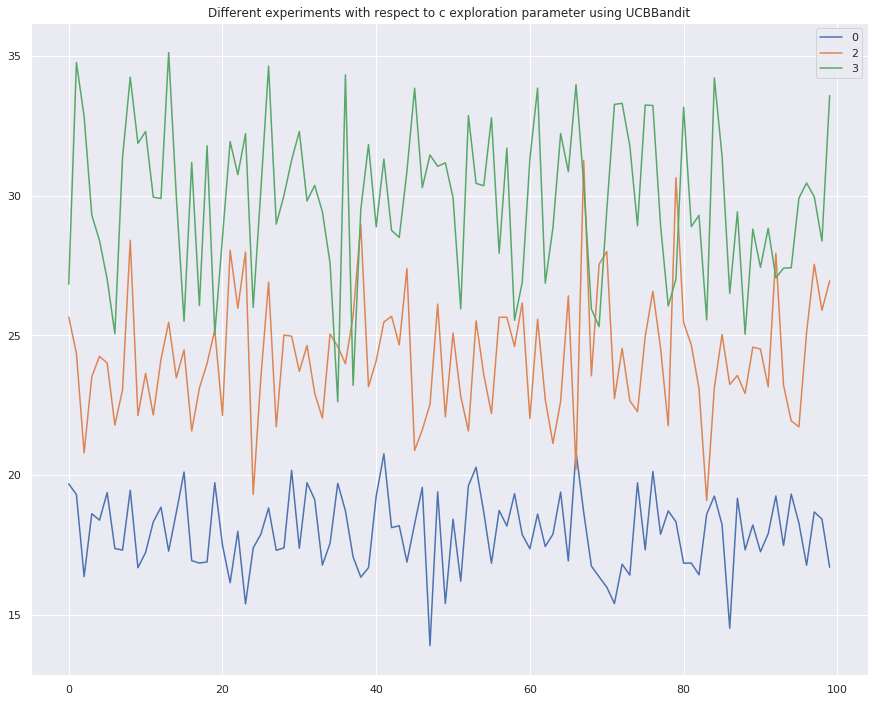

In [21]:
dict_rewards = run_experiments(5, 10000,'ucb')

  0%|          | 0/10000 [00:00<?, ?it/s]/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in add
100%|██████████| 10000/10000 [00:00<00:00, 36639.28it/s]


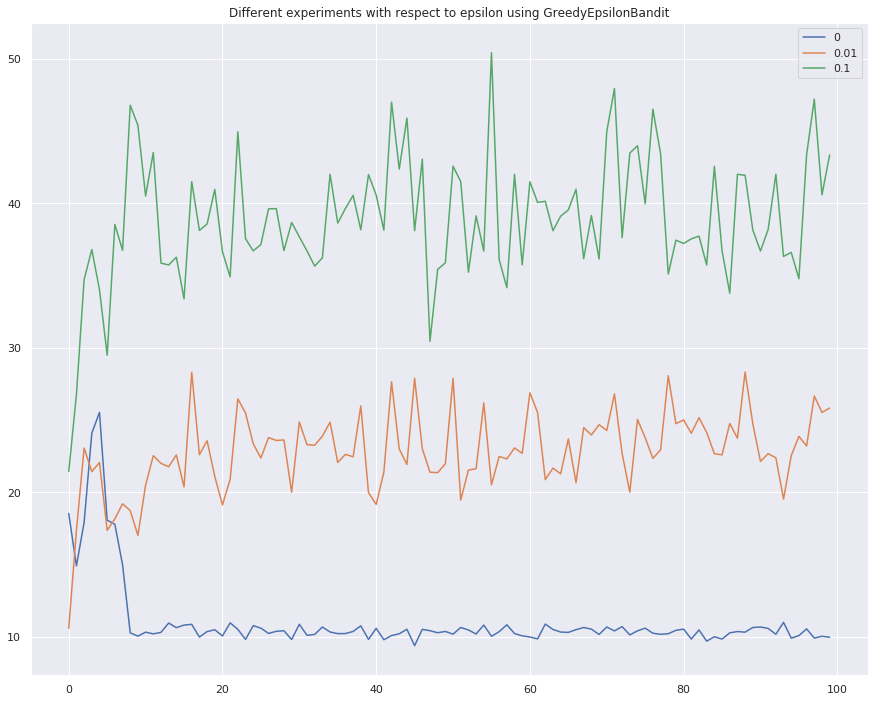

In [17]:
dict_rewards = run_experiments(5, 10000,'epsilons')

  0%|          | 0/10000 [00:00<?, ?it/s]/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in add
100%|██████████| 10000/10000 [00:00<00:00, 43811.88it/s]


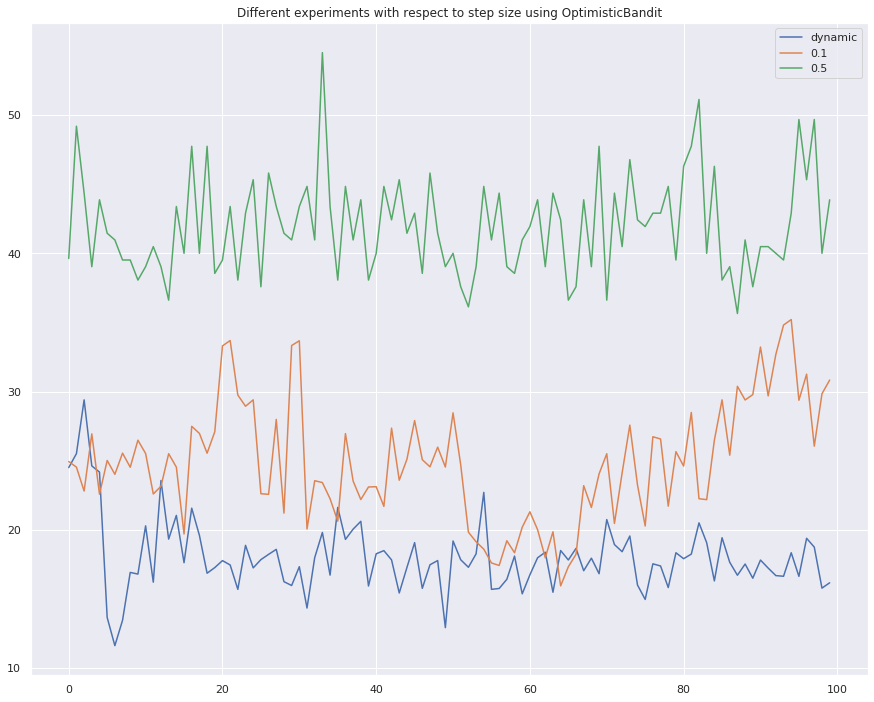

In [19]:
dict_rewards = run_experiments(5, 10000,'optimistic')

100%|██████████| 100000/100000 [00:01<00:00, 54573.50it/s]


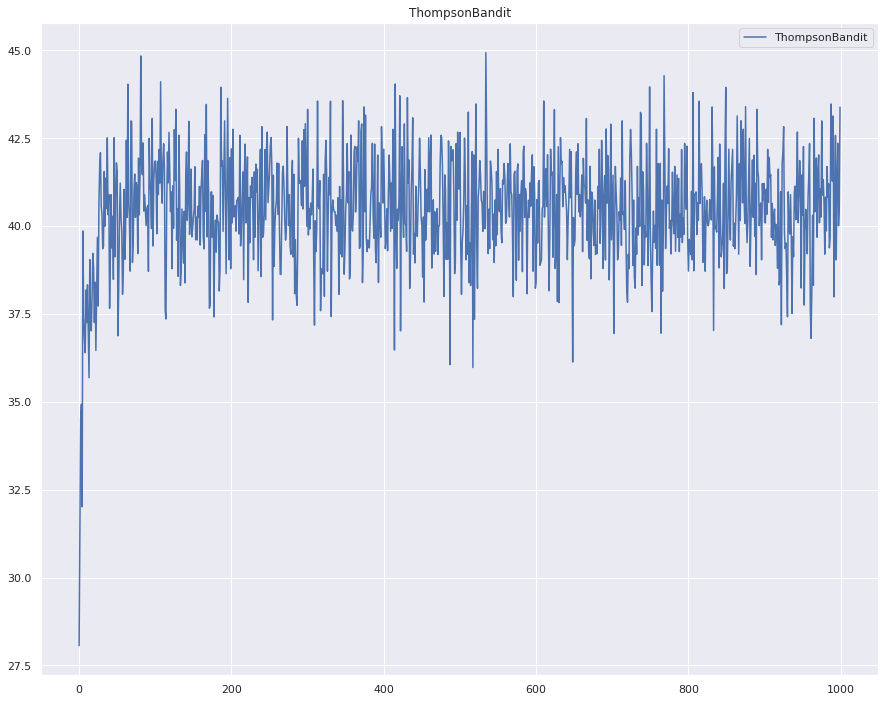

In [10]:
dict_rewards = run_experiments(30, 100000,'thompson')